In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from dynaconf import Dynaconf

from llmcoder.utils import get_config_dir, get_data_dir

In [3]:
# Get all configs
config_dir = get_config_dir()
config_file_list = sorted(file for file in os.listdir(config_dir) if file.endswith(".yaml"))
config_list = [Dynaconf(settings_file=os.path.join(config_dir, config_name)) for config_name in config_file_list]
config_name_list = [os.path.splitext(config_name)[0] for config_name in config_file_list]

for config_name in config_name_list:
    print(config_name)

level_0__ft__mypy__5_steps__1_choice
level_0__ft__mypy_signature_5_steps__1_choice
level_0__ft__mypy_signature_5_steps__3_choices
level_0__ft__mypy_signature_gptscore_5_steps__3_choices
level_0__ft__no_analyzers__1_step
level_0__gpt-3.5__no_analyzers__1_step
level_1__ft__mypy__5_steps__1_choice
level_1__ft__mypy_signature_5_steps__1_choice
level_1__ft__mypy_signature_5_steps__3_choices
level_1__ft__mypy_signature_gptscore_5_steps__3_choices
level_1__ft__no_analyzers__1_step
level_1__gpt-3.5__no_analyzers__1_step
level_2__ft__mypy__5_steps__1_choice
level_2__ft__mypy_signature_5_steps__1_choice
level_2__ft__mypy_signature_5_steps__3_choices
level_2__ft__mypy_signature_gptscore_5_steps__3_choices
level_2__ft__no_analyzers__1_step
level_2__gpt-3.5__no_analyzers__1_step


In [4]:
# /data/name/of/dataset/eval/<config_name>/<run_id>/metrics.csv

In [5]:
# Load all metrics.csv files into a dict
metrics_dict = {}

for config_name, config in zip(config_name_list, config_list):
    dataset = config.get('dataset')
    path_to_eval = os.path.join(get_data_dir(dataset), 'eval', config_name)

    metrics_dict[config_name] = {}

    for run_id in os.listdir(path_to_eval):
        path_to_metrics = os.path.join(path_to_eval, run_id, 'metrics.csv')
        if os.path.exists(path_to_metrics):
            with open(path_to_metrics, 'r') as f:
                metrics_dict[config_name][run_id] = pd.read_csv(f, index_col=0)

In [6]:
# Dimensions: (config, run, example, metric)

In [7]:
metrics_dict['level_0__ft__mypy__5_steps__1_choice']['2024-01-13_16-46-25']

,levenshtein_distance_score,bleu_score,trf_similarity_score,sequence_matcher_score,gpt_reviewer_score,loops_required_score,tokens_used_score,agility_score,time_score
0,0,1.000000,1.000000,1.000000,0.0,0,299,0.0,0.510669
1,298,0.111787,0.813752,0.456835,0.0,0,1075,0.0,1.627634
2,255,0.296616,0.693067,0.419530,-4.0,5,3955,0.0,18.539025
3,93,0.381036,0.855461,0.686869,-2.0,0,481,0.0,0.694365


## Average across runs

In [8]:
for k, v in metrics_dict.items():
    metrics_dict[k]['mean'] = pd.concat(v.values()).groupby(level=0).mean()
    metrics_dict[k]['std'] = pd.concat(v.values()).groupby(level=0).std()
    metrics_dict[k]['median'] = pd.concat(v.values()).groupby(level=0).median()
    metrics_dict[k]['min'] = pd.concat(v.values()).groupby(level=0).min()
    metrics_dict[k]['max'] = pd.concat(v.values()).groupby(level=0).max()
    metrics_dict[k]['25%'] = pd.concat(v.values()).groupby(level=0).quantile(0.25)
    metrics_dict[k]['75%'] = pd.concat(v.values()).groupby(level=0).quantile(0.75)

In [9]:
# Split the metrics into `level_0`, `level_1`, and `level_2` difficulties
metrics_dict_levels = {}

for k, v in metrics_dict.items():
    level = k.split('__')[0]

    if level not in metrics_dict_levels:
        metrics_dict_levels[level] = {}

    metrics_dict_levels[level][k] = v

In [10]:
metrics_dict_levels['level_0']['level_0__ft__mypy__5_steps__1_choice']['mean']

,levenshtein_distance_score,bleu_score,trf_similarity_score,sequence_matcher_score,gpt_reviewer_score,loops_required_score,tokens_used_score,agility_score,time_score
0,0.0,1.000000,1.000000,1.000000,0.0,0.0,299.0,0.0,0.514487
1,298.5,0.109268,0.800504,0.441030,0.5,2.5,3332.0,0.0,20.665795
2,312.0,0.148308,0.380148,0.217517,-7.0,3.0,2701.0,0.5,14.006182
3,93.0,0.381036,0.855461,0.686869,-2.0,0.0,481.0,0.0,0.731782


In [11]:
metric_names = list(metrics_dict_levels['level_0']['level_0__ft__mypy__5_steps__1_choice']['mean'].columns)

In [21]:
for config_name in config_name_list:
    print(config_name)

level_0__ft__mypy__5_steps__1_choice
level_0__ft__mypy_signature_5_steps__1_choice
level_0__ft__mypy_signature_5_steps__3_choices
level_0__ft__mypy_signature_gptscore_5_steps__3_choices
level_0__ft__no_analyzers__1_step
level_0__gpt-3.5__no_analyzers__1_step
level_1__ft__mypy__5_steps__1_choice
level_1__ft__mypy_signature_5_steps__1_choice
level_1__ft__mypy_signature_5_steps__3_choices
level_1__ft__mypy_signature_gptscore_5_steps__3_choices
level_1__ft__no_analyzers__1_step
level_1__gpt-3.5__no_analyzers__1_step
level_2__ft__mypy__5_steps__1_choice
level_2__ft__mypy_signature_5_steps__1_choice
level_2__ft__mypy_signature_5_steps__3_choices
level_2__ft__mypy_signature_gptscore_5_steps__3_choices
level_2__ft__no_analyzers__1_step
level_2__gpt-3.5__no_analyzers__1_step


In [27]:
def sorted_config_names(level):
    return [
        f"level_{level}__gpt-3.5__no_analyzers__1_step",
        f"level_{level}__ft__no_analyzers__1_step",
        f"level_{level}__ft__mypy__5_steps__1_choice",
        f"level_{level}__ft__mypy_signature_5_steps__1_choice",
        f"level_{level}__ft__mypy_signature_5_steps__3_choices",
        f"level_{level}__ft__mypy_signature_gptscore_5_steps__3_choices",
    ]

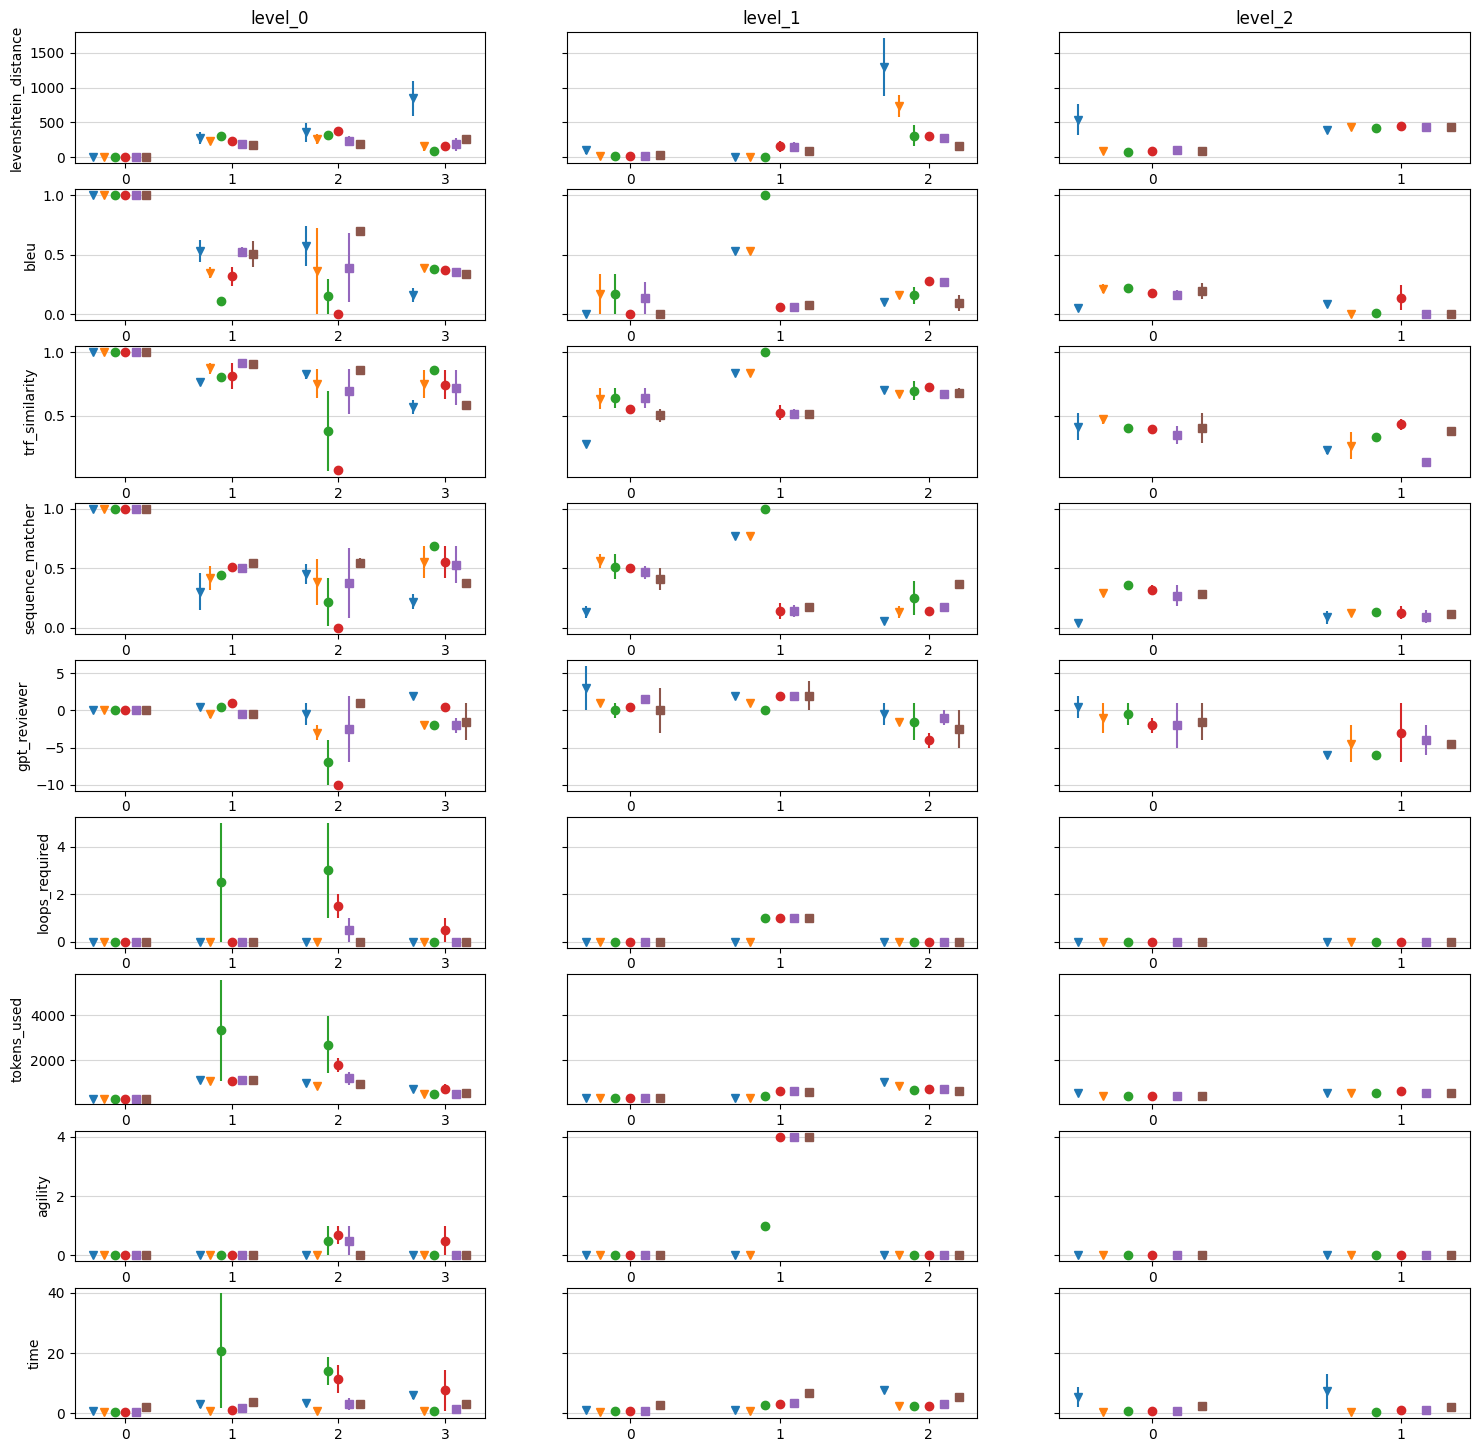

In [34]:
fig, axes = plt.subplots(len(metric_names), 3, figsize=(18, len(metric_names)*2), sharey='row')

for i, (metric, ax_row) in enumerate(zip(metric_names, axes)):
    for level, ax in enumerate(ax_row):
        for c, config_name in enumerate(sorted_config_names(level)):
            metrics = metrics_dict_levels[f'level_{level}'][config_name]

            x = metrics['mean'].index + 0.1 * (c - len(sorted_config_names(level)) / 2)
            y = metrics['mean'][metric]
            yerr = metrics['std'][metric]

            if '3_choice' in config_name:
                fmt = 's'
            elif '1_step' in config_name:
                fmt = 'v'
            else:
                fmt = 'o'

            ax.errorbar(x, y, yerr=yerr, fmt=fmt, label=config_name)

            ax.set_xticks(metrics['mean'].index)

        if i == 0:
            ax.set_title(f'level_{level}')

        if level == 0:
            ax.set_ylabel('_'.join(metric.split('_')[:-1]))

        ax.grid(axis='y', alpha=0.5)

In [71]:
# Create a combined, formatted dataframe with each value formatted as `mean ± std`

for k, v in metrics_dict.items():
    metrics_dict[k]['formatted'] = pd.DataFrame(index=metrics_dict[k]['mean'].index, columns=metrics_dict[k]['mean'].columns)
    for col in metrics_dict[k]['mean'].columns:
        metrics_dict[k]['formatted'][col] = metrics_dict[k]['mean'][col].astype(float).map("{:.1f}".format) + ' ± ' + metrics_dict[k]['std'][col].astype(float).map("{:.1f}".format)

In [74]:
for k, v in metrics_dict.items():
    print(k)
    display(metrics_dict[k]['formatted'])
    print()

level_0__ft__mypy__5_steps__1_choice


,levenshtein_distance_score,bleu_score,trf_similarity_score,sequence_matcher_score,gpt_reviewer_score,loops_required_score,tokens_used_score,agility_score,time_score
0,0.0 ± 0.0,1.0 ± 0.0,1.0 ± 0.0,1.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,299.0 ± 0.0,0.0 ± 0.0,0.5 ± 0.0
1,298.5 ± 0.2,0.1 ± 0.0,0.8 ± 0.0,0.4 ± 0.0,0.5 ± 0.2,2.5 ± 4.2,3332.0 ± 3396032.7,0.0 ± 0.0,20.7 ± 241.6
2,312.0 ± 2166.0,0.1 ± 0.0,0.4 ± 0.1,0.2 ± 0.0,-7.0 ± 6.0,3.0 ± 2.7,2701.0 ± 1048344.0,0.5 ± 0.2,14.0 ± 13.7
3,93.0 ± 0.0,0.4 ± 0.0,0.9 ± 0.0,0.7 ± 0.0,-2.0 ± 0.0,0.0 ± 0.0,481.0 ± 0.0,0.0 ± 0.0,0.7 ± 0.0



level_0__ft__mypy_signature_5_steps__1_choice


,levenshtein_distance_score,bleu_score,trf_similarity_score,sequence_matcher_score,gpt_reviewer_score,loops_required_score,tokens_used_score,agility_score,time_score
0,0.0 ± 0.0,1.0 ± 0.0,1.0 ± 0.0,1.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,299.0 ± 0.0,0.0 ± 0.0,0.5 ± 0.0
1,233.5 ± 748.2,0.3 ± 0.0,0.8 ± 0.0,0.5 ± 0.0,1.0 ± 0.0,0.0 ± 0.0,1085.5 ± 204.2,0.0 ± 0.0,1.2 ± 0.0
2,374.0 ± 0.0,0.0 ± 0.0,0.1 ± 0.0,0.0 ± 0.0,-10.0 ± 0.0,1.5 ± 0.2,1781.5 ± 68480.2,0.7 ± 0.1,11.4 ± 13.7
3,158.5 ± 2860.2,0.4 ± 0.0,0.7 ± 0.0,0.6 ± 0.0,0.5 ± 0.2,0.5 ± 0.2,722.5 ± 38881.5,0.5 ± 0.2,7.6 ± 30.9



level_0__ft__mypy_signature_5_steps__3_choices


,levenshtein_distance_score,bleu_score,trf_similarity_score,sequence_matcher_score,gpt_reviewer_score,loops_required_score,tokens_used_score,agility_score,time_score
0,0.0 ± 0.0,1.0 ± 0.0,1.0 ± 0.0,1.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,299.0 ± 0.0,0.0 ± 0.0,0.6 ± 0.0
1,182.0 ± 192.7,0.5 ± 0.0,0.9 ± 0.0,0.5 ± 0.0,-0.5 ± 0.2,0.0 ± 0.0,1120.5 ± 28.2,0.0 ± 0.0,1.8 ± 0.0
2,235.0 ± 3456.0,0.4 ± 0.1,0.7 ± 0.0,0.4 ± 0.1,-2.5 ± 13.5,0.5 ± 0.2,1207.0 ± 57624.0,0.5 ± 0.2,3.1 ± 2.5
3,182.0 ± 5280.7,0.4 ± 0.0,0.7 ± 0.0,0.5 ± 0.0,-2.0 ± 0.7,0.0 ± 0.0,520.5 ± 1040.2,0.0 ± 0.0,1.4 ± 0.0



level_0__ft__mypy_signature_gptscore_5_steps__3_choices


,levenshtein_distance_score,bleu_score,trf_similarity_score,sequence_matcher_score,gpt_reviewer_score,loops_required_score,tokens_used_score,agility_score,time_score
0,0.0 ± 0.0,1.0 ± 0.0,1.0 ± 0.0,1.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,299.0 ± 0.0,0.0 ± 0.0,2.3 ± 0.0
1,174.5 ± 433.5,0.5 ± 0.0,0.9 ± 0.0,0.5 ± 0.0,-0.5 ± 0.2,0.0 ± 0.0,1114.0 ± 96.0,0.0 ± 0.0,3.7 ± 0.4
2,194.5 ± 160.2,0.7 ± 0.0,0.9 ± 0.0,0.5 ± 0.0,1.0 ± 0.0,0.0 ± 0.0,928.5 ± 48.2,0.0 ± 0.0,3.0 ± 0.0
3,264.0 ± 54.0,0.3 ± 0.0,0.6 ± 0.0,0.4 ± 0.0,-1.5 ± 4.2,0.0 ± 0.0,564.5 ± 1.5,0.0 ± 0.0,3.0 ± 0.0



level_0__ft__no_analyzers__1_step


,levenshtein_distance_score,bleu_score,trf_similarity_score,sequence_matcher_score,gpt_reviewer_score,loops_required_score,tokens_used_score,agility_score,time_score
0,0.0 ± 0.0,1.0 ± 0.0,1.0 ± 0.0,1.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,299.0 ± 0.0,0.0 ± 0.0,0.4 ± 0.0
1,226.0 ± 450.7,0.3 ± 0.0,0.9 ± 0.0,0.4 ± 0.0,-0.5 ± 0.2,0.0 ± 0.0,1092.0 ± 66.7,0.0 ± 0.0,0.9 ± 0.0
2,261.0 ± 3552.7,0.4 ± 0.1,0.8 ± 0.0,0.4 ± 0.0,-3.0 ± 0.7,0.0 ± 0.0,878.0 ± 1350.0,0.0 ± 0.0,0.8 ± 0.1
3,157.0 ± 2730.7,0.4 ± 0.0,0.7 ± 0.0,0.6 ± 0.0,-2.0 ± 0.0,0.0 ± 0.0,513.0 ± 682.7,0.0 ± 0.0,0.7 ± 0.0



level_0__gpt-3.5__no_analyzers__1_step


,levenshtein_distance_score,bleu_score,trf_similarity_score,sequence_matcher_score,gpt_reviewer_score,loops_required_score,tokens_used_score,agility_score,time_score
0,0.0 ± 0.0,1.0 ± 0.0,1.0 ± 0.0,1.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,299.0 ± 0.0,0.0 ± 0.0,0.7 ± 0.0
1,278.5 ± 4648.2,0.5 ± 0.0,0.8 ± 0.0,0.3 ± 0.0,0.5 ± 0.2,0.0 ± 0.0,1143.5 ± 181.5,0.0 ± 0.0,3.0 ± 0.8
2,354.5 ± 13160.2,0.6 ± 0.0,0.8 ± 0.0,0.5 ± 0.0,-0.5 ± 1.5,0.0 ± 0.0,977.0 ± 1176.0,0.0 ± 0.0,3.4 ± 0.2
3,847.5 ± 41500.2,0.2 ± 0.0,0.6 ± 0.0,0.2 ± 0.0,2.0 ± 0.0,0.0 ± 0.0,743.0 ± 1666.7,0.0 ± 0.0,6.2 ± 1.1



level_1__ft__mypy__5_steps__1_choice


,levenshtein_distance_score,bleu_score,trf_similarity_score,sequence_matcher_score,gpt_reviewer_score,loops_required_score,tokens_used_score,agility_score,time_score
0,16.5 ± 8.2,0.2 ± 0.0,0.6 ± 0.0,0.5 ± 0.0,0.0 ± 0.7,0.0 ± 0.0,318.5 ± 0.2,0.0 ± 0.0,0.8 ± 0.0
1,0.0 ± 0.0,1.0 ± 0.0,1.0 ± 0.0,1.0 ± 0.0,0.0 ± 0.0,1.0 ± 0.0,422.0 ± 0.0,1.0 ± 0.0,2.7 ± 0.0
2,308.0 ± 14406.0,0.2 ± 0.0,0.7 ± 0.0,0.2 ± 0.0,-1.5 ± 4.2,0.0 ± 0.0,695.5 ± 3700.2,0.0 ± 0.0,2.3 ± 0.2



level_1__ft__mypy_signature_5_steps__1_choice


,levenshtein_distance_score,bleu_score,trf_similarity_score,sequence_matcher_score,gpt_reviewer_score,loops_required_score,tokens_used_score,agility_score,time_score
0,18.0 ± 0.0,0.0 ± 0.0,0.6 ± 0.0,0.5 ± 0.0,0.5 ± 0.2,0.0 ± 0.0,319.0 ± 0.0,0.0 ± 0.0,0.7 ± 0.0
1,156.0 ± 4374.0,0.1 ± 0.0,0.5 ± 0.0,0.1 ± 0.0,2.0 ± 0.0,1.0 ± 0.0,631.5 ± 620.2,4.0 ± 0.0,3.1 ± 0.0
2,305.5 ± 1768.2,0.3 ± 0.0,0.7 ± 0.0,0.1 ± 0.0,-4.0 ± 0.7,0.0 ± 0.0,730.5 ± 228.2,0.0 ± 0.0,2.5 ± 0.0



level_1__ft__mypy_signature_5_steps__3_choices


,levenshtein_distance_score,bleu_score,trf_similarity_score,sequence_matcher_score,gpt_reviewer_score,loops_required_score,tokens_used_score,agility_score,time_score
0,17.5 ± 4.2,0.1 ± 0.0,0.6 ± 0.0,0.5 ± 0.0,1.5 ± 0.2,0.0 ± 0.0,318.5 ± 0.2,0.0 ± 0.0,0.8 ± 0.0
1,146.5 ± 2688.2,0.1 ± 0.0,0.5 ± 0.0,0.1 ± 0.0,2.0 ± 0.0,1.0 ± 0.0,628.0 ± 450.7,4.0 ± 0.0,3.5 ± 0.1
2,270.0 ± 912.7,0.3 ± 0.0,0.7 ± 0.0,0.2 ± 0.0,-1.0 ± 0.7,0.0 ± 0.0,715.0 ± 150.0,0.0 ± 0.0,3.2 ± 0.1



level_1__ft__mypy_signature_gptscore_5_steps__3_choices


,levenshtein_distance_score,bleu_score,trf_similarity_score,sequence_matcher_score,gpt_reviewer_score,loops_required_score,tokens_used_score,agility_score,time_score
0,29.5 ± 88.2,0.0 ± 0.0,0.5 ± 0.0,0.4 ± 0.0,0.0 ± 6.0,0.0 ± 0.0,325.0 ± 24.0,0.0 ± 0.0,2.9 ± 0.2
1,94.5 ± 4.2,0.1 ± 0.0,0.5 ± 0.0,0.2 ± 0.0,2.0 ± 2.7,1.0 ± 0.0,605.5 ± 0.2,4.0 ± 0.0,6.9 ± 0.0
2,163.5 ± 37.5,0.1 ± 0.0,0.7 ± 0.0,0.4 ± 0.0,-2.5 ± 4.2,0.0 ± 0.0,620.5 ± 60.2,0.0 ± 0.0,5.3 ± 0.4



level_1__ft__no_analyzers__1_step


,levenshtein_distance_score,bleu_score,trf_similarity_score,sequence_matcher_score,gpt_reviewer_score,loops_required_score,tokens_used_score,agility_score,time_score
0,15.5 ± 4.2,0.2 ± 0.0,0.6 ± 0.0,0.6 ± 0.0,1.0 ± 0.0,0.0 ± 0.0,318.5 ± 0.2,0.0 ± 0.0,0.4 ± 0.0
1,6.0 ± 0.0,0.5 ± 0.0,0.8 ± 0.0,0.8 ± 0.0,1.0 ± 0.0,0.0 ± 0.0,317.0 ± 0.0,0.0 ± 0.0,0.9 ± 0.2
2,729.0 ± 16854.0,0.2 ± 0.0,0.7 ± 0.0,0.1 ± 0.0,-1.5 ± 0.2,0.0 ± 0.0,876.0 ± 3650.7,0.0 ± 0.0,2.6 ± 0.2



level_1__gpt-3.5__no_analyzers__1_step


,levenshtein_distance_score,bleu_score,trf_similarity_score,sequence_matcher_score,gpt_reviewer_score,loops_required_score,tokens_used_score,agility_score,time_score
0,97.0 ± 1472.7,0.0 ± 0.0,0.3 ± 0.0,0.1 ± 0.0,3.0 ± 6.0,0.0 ± 0.0,343.5 ± 160.2,0.0 ± 0.0,1.2 ± 0.1
1,6.0 ± 0.0,0.5 ± 0.0,0.8 ± 0.0,0.8 ± 0.0,2.0 ± 0.0,0.0 ± 0.0,317.0 ± 0.0,0.0 ± 0.0,1.0 ± 0.0
2,1292.5 ± 116761.5,0.1 ± 0.0,0.7 ± 0.0,0.1 ± 0.0,-0.5 ± 1.5,0.0 ± 0.0,1030.0 ± 11616.0,0.0 ± 0.0,7.9 ± 0.4



level_2__ft__mypy__5_steps__1_choice


,levenshtein_distance_score,bleu_score,trf_similarity_score,sequence_matcher_score,gpt_reviewer_score,loops_required_score,tokens_used_score,agility_score,time_score
0,66.5 ± 0.2,0.2 ± 0.0,0.4 ± 0.0,0.4 ± 0.0,-0.5 ± 1.5,0.0 ± 0.0,419.0 ± 0.0,0.0 ± 0.0,0.7 ± 0.0
1,423.0 ± 6.0,0.0 ± 0.0,0.3 ± 0.0,0.1 ± 0.0,-6.0 ± 0.0,0.0 ± 0.0,536.5 ± 1.5,0.0 ± 0.0,0.5 ± 0.0



level_2__ft__mypy_signature_5_steps__1_choice


,levenshtein_distance_score,bleu_score,trf_similarity_score,sequence_matcher_score,gpt_reviewer_score,loops_required_score,tokens_used_score,agility_score,time_score
0,92.5 ± 468.2,0.2 ± 0.0,0.4 ± 0.0,0.3 ± 0.0,-2.0 ± 0.7,0.0 ± 0.0,427.5 ± 37.5,0.0 ± 0.0,0.9 ± 0.0
1,445.5 ± 1093.5,0.1 ± 0.0,0.4 ± 0.0,0.1 ± 0.0,-3.0 ± 10.7,0.0 ± 0.0,634.5 ± 3504.2,0.0 ± 0.0,1.3 ± 0.3



level_2__ft__mypy_signature_5_steps__3_choices


,levenshtein_distance_score,bleu_score,trf_similarity_score,sequence_matcher_score,gpt_reviewer_score,loops_required_score,tokens_used_score,agility_score,time_score
0,100.0 ± 770.7,0.2 ± 0.0,0.4 ± 0.0,0.3 ± 0.0,-2.0 ± 6.0,0.0 ± 0.0,429.5 ± 60.2,0.0 ± 0.0,0.8 ± 0.0
1,438.0 ± 96.0,0.0 ± 0.0,0.1 ± 0.0,0.1 ± 0.0,-4.0 ± 2.7,0.0 ± 0.0,533.5 ± 1.5,0.0 ± 0.0,1.0 ± 0.1



level_2__ft__mypy_signature_gptscore_5_steps__3_choices


,levenshtein_distance_score,bleu_score,trf_similarity_score,sequence_matcher_score,gpt_reviewer_score,loops_required_score,tokens_used_score,agility_score,time_score
0,84.0 ± 864.0,0.2 ± 0.0,0.4 ± 0.0,0.3 ± 0.0,-1.5 ± 4.2,0.0 ± 0.0,422.0 ± 112.7,0.0 ± 0.0,2.3 ± 0.0
1,426.0 ± 0.0,0.0 ± 0.0,0.4 ± 0.0,0.1 ± 0.0,-4.5 ± 0.2,0.0 ± 0.0,534.0 ± 0.0,0.0 ± 0.0,2.1 ± 0.0



level_2__ft__no_analyzers__1_step


,levenshtein_distance_score,bleu_score,trf_similarity_score,sequence_matcher_score,gpt_reviewer_score,loops_required_score,tokens_used_score,agility_score,time_score
0,85.0 ± 192.7,0.2 ± 0.0,0.5 ± 0.0,0.3 ± 0.0,-1.0 ± 2.7,0.0 ± 0.0,423.5 ± 20.2,0.0 ± 0.0,0.6 ± 0.0
1,431.5 ± 20.2,0.0 ± 0.0,0.3 ± 0.0,0.1 ± 0.0,-4.5 ± 4.2,0.0 ± 0.0,534.5 ± 0.2,0.0 ± 0.0,0.5 ± 0.0



level_2__gpt-3.5__no_analyzers__1_step


,levenshtein_distance_score,bleu_score,trf_similarity_score,sequence_matcher_score,gpt_reviewer_score,loops_required_score,tokens_used_score,agility_score,time_score
0,537.5 ± 32413.5,0.0 ± 0.0,0.4 ± 0.0,0.0 ± 0.0,0.5 ± 1.5,0.0 ± 0.0,562.5 ± 4004.2,0.0 ± 0.0,5.4 ± 7.1
1,384.0 ± 42.7,0.1 ± 0.0,0.2 ± 0.0,0.1 ± 0.0,-6.0 ± 0.0,0.0 ± 0.0,564.5 ± 28.2,0.0 ± 0.0,7.3 ± 22.5
